<a href="https://colab.research.google.com/github/agwn1819/EINT_SS_19/blob/master/Masterarbeit_SVM_Classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Masterabeit : Konzeptionierung und Implementierung einer passiven Authentifizierung zum Lernen und Auswerten von passiv-erhobenen Smartphone-Sensoren, unter Berücksichtigung der DSGVO
## Vergleiche von unterschiedlieche Algrithmen:
## Überwachenes Lernen
## Unübewachenes Lernen
## Deep Learning oder Vertiefen Lernen

## Auto: Armel Wonga, 30.10.2022


# Aufbereiten der Sensordaten

## Importieren von Bib

In [749]:
#### import Library
import numpy as np
import pandas as pd
import glob, os
import itertools
from itertools import *
import time
import datetime

# library for Feature-Engineering
from scipy.signal import find_peaks
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Plotting a Pairplot with sns
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
from datetime import datetime

# import SVC classifier
from sklearn.svm import SVC
## Import data Processing module
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# import metrics to compute accuracy (Evaluate)
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
# from sklearn.inspection import 
# DecisionBoundaryDisplay

##  Importieren von Datensätzen

In [750]:
path_dir_riskuser_1 = "/content/drive/MyDrive/Masterarbeit_2021-2022/datasets/Test_Person_1_20B_Rechte_Hand_Raw_data_riskUser/" # Rechte Hand
path_dir_riskuser_2 = "/content/drive/MyDrive/Masterarbeit_2021-2022/datasets/Test_P1_Stehen_RechterHand/" # Rechte Hand
path_dir_riskuser_3 = "/content/drive/MyDrive/Masterarbeit_2021-2022/datasets/Test_P1_Stehen_LinkerHand/"  # Linke Hand
path_dir_normalUser_RH = "/content/drive/MyDrive/Masterarbeit_2021-2022/datasets/Test_Person_2_20B_Linke_Hand_Raw_data_NormalUser/" # Rechte Hand
path_dir_normalUser_LH = "/content/drive/MyDrive/Masterarbeit_2021-2022/datasets/Test_Person_2_20B_Rechte_Hand_Raw_data_NormalUser/"  # Linke Hand

## Erzeugen den Datensätze für den legitmeren User
#### sensordaten von linker Hand und Rechter Hand Bewegungen.

In [751]:
def concatenateSensorsData_nU(dataPath, classes):
    #global df_GyroSensors
    sensors_files = glob.glob(dataPath + "*.csv")
    for filename in os.listdir(dataPath):
        sensor_file = os.sep.join([dataPath, filename])
        basename = os.path.basename(sensor_file)
        if  basename == "SensorDataAccel.csv":
            headers = ['Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Timestamps']
            # read_csv as pandas data frame
            df_AccelSensors = pd.read_csv(sensor_file, names=headers)
            #  add the features classes of the sensors_files
            df_AccelSensors['classes'] = pd.Series([classes for x in range(len(df_AccelSensors.index))])
            # print(df_AccelSensors.head(10))

        if  basename == "SensorDataGrav.csv":
            #print(sensor_file)
            headers = ['Gravity_X', 'Gravity_Y', 'Gravity_Z', 'Timestamps']
            # read_csv as pandas data frame
            df_GravSensors = pd.read_csv( sensor_file, names=headers)
            #  add the features classes of the sensors_files
            df_GravSensors['classes'] = pd.Series([classes for x in range(len(df_GravSensors.index))])
            #print(df_GravSensors.head(10))

        if  basename == "SensorDataGyros.csv":
            #print(sensor_file)
            headers = ['Gyroscope_X', 'Gyroscope_Y', 'Gyroscope_Z', 'Timestamps']
            # read_csv as pandas data frame
            df_GyroSensors = pd.read_csv( sensor_file, names=headers)
            #  add the features classes of the sensors_files
            df_GyroSensors['classes'] = pd.Series([classes for x in range(len(df_GyroSensors.index))])
            #print(df_GyroSensors)
    df = pd.concat([df_GyroSensors, df_GravSensors, df_AccelSensors], axis=1)
    # # Drop duplicate columns
    # # Use groupby() to drop duplicate columns
    df = df.T.groupby(level=0).first().T
    # print(df)
    # print("len of Data: {}".format(df.shape))
    return  df
    #df.to_csv('df_highRiskUsers.csv')
    #df.to_csv('df_mediumRiskUsers.csv')
    #df.to_csv('df_normalUsers.csv')

# Label an datensatz setzen
classes = 'legitimeruser'
df_LH = concatenateSensorsData_nU(path_dir_normalUser_RH,classes)
df_RH = concatenateSensorsData_nU(path_dir_normalUser_LH, classes)

# Verkettung der Datensätze
df_sensordata_LU = pd.concat([df_LH, df_RH])
df_sensordata_LU

,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,Gravity_X,Gravity_Y,Gravity_Z,Gyroscope_X,Gyroscope_Y,Gyroscope_Z,Timestamps,classes
0,0.03,-0.01,0.0,0.0,0.04,9.81,0.87,1.71,-0.0,13772928377d 10h 19m 26s,legitimeruser
1,0.02,-0.01,0.0,0.01,0.03,9.81,0.08,0.14,0.12,13772930652d 22h 8m 38s,legitimeruser
2,-0.0,0.0,0.0,0.01,0.03,9.81,-0.07,-0.1,0.05,13772932928d 9h 30m 56s,legitimeruser
3,-0.0,0.0,0.0,0.01,0.03,9.81,-0.03,-0.02,0.04,13772935203d 21h 19m 16s,legitimeruser
4,0.0,-0.0,0.0,0.01,0.04,9.81,0.06,0.11,0.03,13772937479d 8h 39m 49s,legitimeruser
...,...,...,...,...,...,...,...,...,...,...,...
170,-0.51,1.11,0.51,0.51,3.36,9.2,-12.99,-4.22,6.66,803663391998854,legitimeruser
171,-0.68,-0.09,1.84,0.59,3.36,9.19,6.52,0.52,11.58,803663588532031,legitimeruser
172,-1.03,-1.38,1.88,1.34,4.17,8.78,28.91,-11.84,34.16,803663785066926,legitimeruser
173,-0.84,-1.5,0.4,1.43,4.71,8.48,21.57,-2.69,2.46,803663981600156,legitimeruser


## Erzeugen den Datensätze für den illegitmeren User

In [752]:
def concatenateSensorsData_nU(dataPath, classes):
    #global df_GyroSensors
    sensors_files = glob.glob(dataPath + "*.csv")
    for filename in os.listdir(dataPath):
        sensor_file = os.sep.join([dataPath, filename])
        basename = os.path.basename(sensor_file)
        if  basename == "SensorDataAccel.csv":
            headers = ['Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Timestamps']
            # read_csv as pandas data frame
            df_AccelSensors = pd.read_csv(sensor_file, names=headers)
            #  add the features classes of the sensors_files
            df_AccelSensors['classes'] = pd.Series([classes for x in range(len(df_AccelSensors.index))])
            # print(df_AccelSensors.head(10))

        if  basename == "SensorDataGrav.csv":
            #print(sensor_file)
            headers = ['Gravity_X', 'Gravity_Y', 'Gravity_Z', 'Timestamps']
            # read_csv as pandas data frame
            df_GravSensors = pd.read_csv( sensor_file, names=headers)
            #  add the features classes of the sensors_files
            df_GravSensors['classes'] = pd.Series([classes for x in range(len(df_GravSensors.index))])
            #print(df_GravSensors.head(10))

        if  basename == "SensorDataGyros.csv":
            #print(sensor_file)
            headers = ['Gyroscope_X', 'Gyroscope_Y', 'Gyroscope_Z', 'Timestamps']
            # read_csv as pandas data frame
            df_GyroSensors = pd.read_csv( sensor_file, names=headers)
            #  add the features classes of the sensors_files
            df_GyroSensors['classes'] = pd.Series([classes for x in range(len(df_GyroSensors.index))])
            #print(df_GyroSensors)
    df = pd.concat([df_GyroSensors, df_GravSensors, df_AccelSensors], axis=1)
    # # Drop duplicate columns
    # # Use groupby() to drop duplicate columns
    df = df.T.groupby(level=0).first().T
    # print(df)
    # print("len of Data: {}".format(df.shape))
    return  df
    #df.to_csv('df_highRiskUsers.csv')
    #df.to_csv('df_mediumRiskUsers.csv')
    #df.to_csv('df_normalUsers.csv')

# Label an datensatz setzen
classes = 'illegitimeruser'
df_sensordata_IU_1 = concatenateSensorsData_nU(path_dir_riskuser_1,classes)
df_sensordata_IU_2 = concatenateSensorsData_nU(path_dir_riskuser_2,classes)
df_sensordata_IU_3 = concatenateSensorsData_nU(path_dir_riskuser_3,classes)

# Verkettung der Datensätze illgetimerUser
df_sensordata_IU = df_sensordata = pd.concat([df_sensordata_IU_1, df_sensordata_IU_2, df_sensordata_IU_3 ])


##Zusammenführen der SensorDaten beide User
Der Trainingsdatensatz hat also 11 Spalten / Merkmale (einschließlich des Ziels / der Klasse) und 2376 Zeilen oder Datenpunkte.

Auch das Ziel ist Legitimität. Wie in der Datenbeschreibung erwähnt, hat es 2 eindeutige Werte. Lassen Sie uns auch diese im nächsten Schritt überprüfen.

In [753]:
df_sensordata = pd.concat([df_sensordata_LU ,df_sensordata_IU])
df_sensordata

,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,Gravity_X,Gravity_Y,Gravity_Z,Gyroscope_X,Gyroscope_Y,Gyroscope_Z,Timestamps,classes
0,0.03,-0.01,0.0,0.0,0.04,9.81,0.87,1.71,-0.0,13772928377d 10h 19m 26s,legitimeruser
1,0.02,-0.01,0.0,0.01,0.03,9.81,0.08,0.14,0.12,13772930652d 22h 8m 38s,legitimeruser
2,-0.0,0.0,0.0,0.01,0.03,9.81,-0.07,-0.1,0.05,13772932928d 9h 30m 56s,legitimeruser
3,-0.0,0.0,0.0,0.01,0.03,9.81,-0.03,-0.02,0.04,13772935203d 21h 19m 16s,legitimeruser
4,0.0,-0.0,0.0,0.01,0.04,9.81,0.06,0.11,0.03,13772937479d 8h 39m 49s,legitimeruser
...,...,...,...,...,...,...,...,...,...,...,...
507,0.0,0.0,0.0,9.81,9.81,0.0,0.01,0.01,0.0,978571535738354,illegitimeruser
508,0.0,0.0,0.0,9.81,9.81,0.0,0.02,0.02,0.01,978571732320333,illegitimeruser
509,0.0,0.0,0.0,9.81,9.81,0.0,0.02,0.02,0.0,978571928904031,illegitimeruser
510,0.0,0.0,0.0,9.81,9.81,0.0,0.02,0.02,0.0,978572125486062,illegitimeruser


## Prüfen ob NaN-Werten in der Datensätzen vorhanden sind

In [754]:
df_sensordata = df_sensordata.fillna(0)
df_sensordata.isnull().sum()

Accelerometer_X    0
Accelerometer_Y    0
Accelerometer_Z    0
Gravity_X          0
Gravity_Y          0
Gravity_Z          0
Gyroscope_X        0
Gyroscope_Y        0
Gyroscope_Z        0
Timestamps         0
classes            0
dtype: int64

### Erstellen von Labe für die Sensordata

In [755]:
df_sensordata.rename(columns={'classes': 'label'}, inplace=True)
df_sensordata['label'] = df_sensordata.label.astype('category')
encoding = {'illegitimeruser': 1, 'legitimeruser': 0}
df_sensordata.label.replace(encoding, inplace=True)

## Erstelle einen Training- und Test-Datensatz für Feature Engineering

Erstens gibt es den Parameter random_
state, der den Seed-Wert des Zufallszahlengenerators festlegt. Und zweitens können Sie mehrere Datensätze mit einer identischen Anzahl Zeilen übergeben, die anhand der gleichen Indizes aufgeteilt werden

In [756]:
train_set, test_set = train_test_split(df_sensordata, test_size=0.2, random_state=0)

#### Größe der Trainingdatensatz ermitteln

In [757]:
train_set

,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,Gravity_X,Gravity_Y,Gravity_Z,Gyroscope_X,Gyroscope_Y,Gyroscope_Z,Timestamps,label
170,0.09,3.35,1.00,0.19,0.28,9.80,-23.61,-1.80,11.62,13773315203d 19h 46m 2s,0
432,0.03,0.03,0.01,9.81,9.81,0.00,107.23,107.23,12.98,978556792107729,1
284,0.03,0.03,0.00,9.81,9.81,0.00,51.17,51.17,41.16,978527698614105,1
355,0.03,0.03,0.00,9.81,9.81,0.00,19.46,19.46,28.69,978541655509708,1
295,0.00,0.00,0.01,9.81,9.81,0.00,0.01,0.01,0.01,978529860929708,1
...,...,...,...,...,...,...,...,...,...,...,...
43,0.03,0.03,0.02,9.81,9.81,0.00,101.74,101.74,12.84,978165176635641,1
18,0.03,0.03,0.00,9.81,9.81,0.00,138.53,138.53,51.95,978475410775928,1
455,0.01,0.01,0.01,9.81,9.81,0.00,7.19,7.19,18.56,978561313470281,1
117,-0.52,-3.28,1.37,-0.17,9.24,3.27,94.58,-47.14,3.00,803652975746669,0


### Größe der Testdatensatz ermitteln

In [758]:
len(test_set)

342

#### create y_train und y_test von Label in nummerische Werten

In [759]:
# y_train = train_set['label'].values
# y_train

In [760]:
# y_test = test_set['label'].values
# y_test

### Anpassen der Spalte Timestampels

#### Scikit-Learn enthält eine nützliche Klasse zum Umgang mit fehlenden Werten
sollten Sie den Median des trainingsdatensatzes berechnen und die fehlenden Werte mit diesem auffüllen.

In [761]:
# new data frame with split value columns
new = train_set["Timestamps"].str.split("d", n = 1, expand = True)
 
# making separate first name column from new data frame
train_set["Timestamps"]= new[0]
 
# making separate last name column from new data frame
train_set["Timestamps_1"]= new[1]
 
# Dropping old Name columns
train_set.drop(columns =["Timestamps_1"], inplace = True)
train_set

,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,Gravity_X,Gravity_Y,Gravity_Z,Gyroscope_X,Gyroscope_Y,Gyroscope_Z,Timestamps,label
170,0.09,3.35,1.00,0.19,0.28,9.80,-23.61,-1.80,11.62,13773315203,0
432,0.03,0.03,0.01,9.81,9.81,0.00,107.23,107.23,12.98,NaN,1
284,0.03,0.03,0.00,9.81,9.81,0.00,51.17,51.17,41.16,NaN,1
355,0.03,0.03,0.00,9.81,9.81,0.00,19.46,19.46,28.69,NaN,1
295,0.00,0.00,0.01,9.81,9.81,0.00,0.01,0.01,0.01,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
43,0.03,0.03,0.02,9.81,9.81,0.00,101.74,101.74,12.84,NaN,1
18,0.03,0.03,0.00,9.81,9.81,0.00,138.53,138.53,51.95,NaN,1
455,0.01,0.01,0.01,9.81,9.81,0.00,7.19,7.19,18.56,NaN,1
117,-0.52,-3.28,1.37,-0.17,9.24,3.27,94.58,-47.14,3.00,NaN,0


#### Fehlenden Werte auf einen bestimmten Wert setzen (null auf Median setzen )

In [762]:
median = train_set["Timestamps"].median() 
train_set["Timestamps"].fillna(median, inplace=True)
train_set.shape
# from sklearn.impute import SimpleImputer

# #  den Median des Trainingsdatensatzes berechnen und die fehlenden Werte mit diesem auffüllen
# # Scikit-Learn enthält eine nützliche Klasse zum Umgang mit fehlenden Werten: SimpleImputer
# imputer = SimpleImputer(strategy="median")
# df_sensordata_timestNum = df_sensordata.drop("classes", axis=1)
# #Anschließend können Sie die imputer-Instanz durch Aufrufen der Methode fit() an die Trainingsdaten anpassen
# imputer.fit(df_sensordata_timestNum)
# #  Der imputer hat einfach den Median jedes Merkmals berechnet und das Ergebnis im Attribut statistics_ gespeichert
# df_sensordata_timestNum.median().values
# imputer.statistics_
# # Sie können nun mit diesem »trainierten« imputer den Trainingsdatensatz transformieren, sodass die fehlenden Werte durch die gefundenen Mediane ersetzt werden
# # X = imputer.transform(df_sensordata_timestNum)
# df_sensordata_timestNum


(1368, 11)

In [763]:
test_set.shape

(342, 11)

## Explorative Datenanalyse


### Plot der Label im Bezug auf die Datensätze pro Nutzer

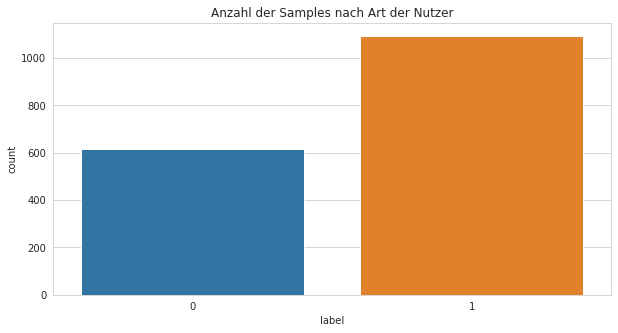

In [764]:
sns.set_style("whitegrid") 
plt.figure(figsize = (10, 5)) 
sns.countplot(x = 'label', data = df_sensordata) 
plt.title('Anzahl der Samples nach Art der Nutzer') 
plt.show( )

### Plot der Sensordaten
### Lassen Sie uns nun sehen, welcher Sensordaten zu welcher Nutzer zugeormet ist. Dies hilft uns bei der Entscheidung, wie die Daten für Training und Test aufgeteilt werden sollen.
Betrachten wir nun die User-Bewegungsverteilung der Sensordaten entlang der x-, y- und z - Achse von jedem Sensor, um zu sehen, ob es ein offensichtliches Muster basierend auf dem Bereich und der Verteilung der Werte gibt.

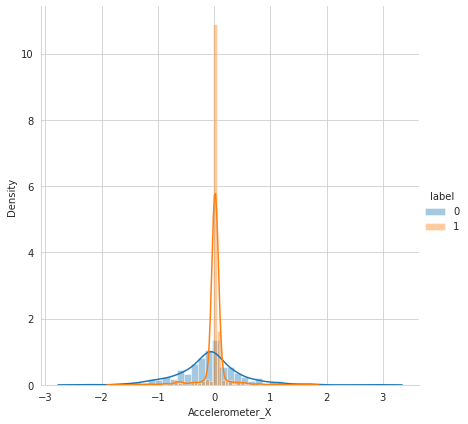

In [765]:
sns.FacetGrid(df_sensordata, hue = 'label', size = 6).map(sns.distplot, 'Accelerometer_X').add_legend()

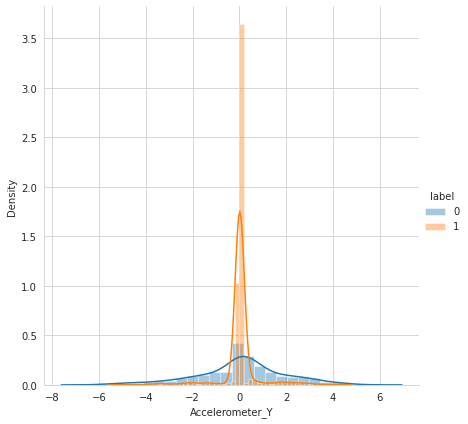

In [766]:
sns.FacetGrid(df_sensordata, hue = 'label', size = 6).map(sns.distplot, 'Accelerometer_Y').add_legend()

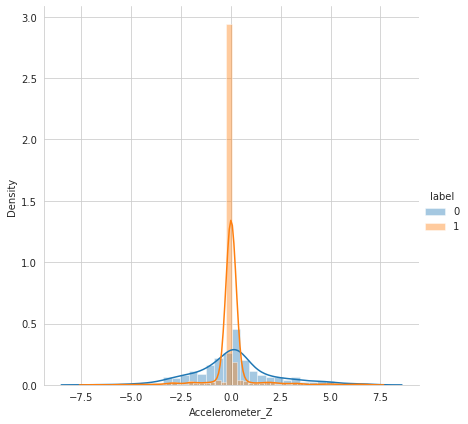

In [767]:
sns.FacetGrid(df_sensordata, hue = 'label', size = 6).map(sns.distplot, 'Accelerometer_Z').add_legend()

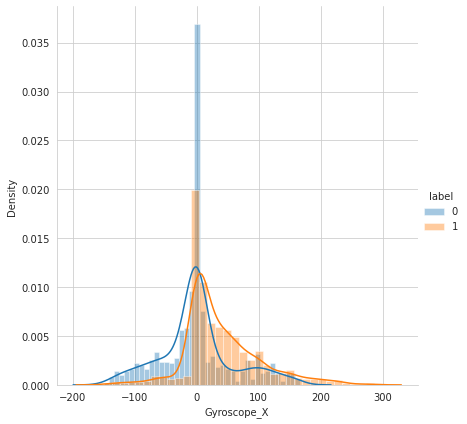

In [768]:
sns.FacetGrid(df_sensordata, hue = 'label', size = 6).map(sns.distplot, 'Gyroscope_X').add_legend()

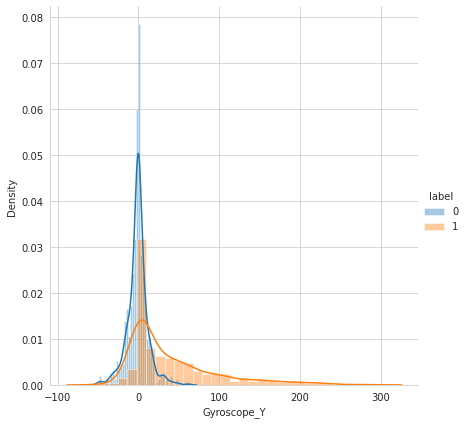

In [769]:
sns.FacetGrid(df_sensordata, hue = 'label', size = 6).map(sns.distplot, 'Gyroscope_Y').add_legend()

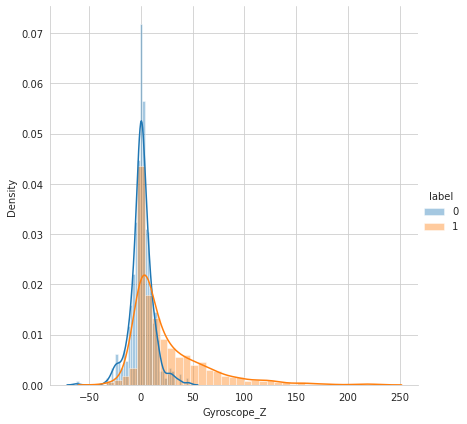

In [770]:
sns.FacetGrid(df_sensordata, hue = 'label', size = 6).map(sns.distplot, 'Gyroscope_Z').add_legend()

#### Lassen Sie uns für einen allem Nutzer beobachten, wie sich die Sensorwertne in jeder der x-, y- und z - Dimensionen mit der Zeit ändern.

Wir haben eine Teilmenge von 400 Proben zur Visualisierung des sensordaten berücksichtigt.

In [771]:
# for i in ['illegitimerUser', 'legitimerUser']: 
#   data_sensors = df_sensordata[(df_sensordata["Accelerometer_X"]==0) & (df_sensordata['classes'] == i)][:400] 
#   plt.figure(figsize = (15, 6)) 
#   sns.lineplot(y = 'Accelerometer_X', x = 'Timestamps', data = data_sensors) 
#   sns.lineplot(y = 'Accelerometer_Y', x = 'Timestamps', data = data_sensors) 
#   sns.lineplot(y = 'Accelerometer_Z', x = 'Timestamps', data = data_sensors) 
#   plt.legend(['Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z']) 
#   plt.ylabel(i) 
#   plt.title(i, fontsize = 15) 
#   plt.show()

Alle Features sind vom Typ float64 und alle 9 sind numerische Features, außer Class (y). Wir müssen Label Encoder machen und sie in numeirc umwandeln.

### Feature-Skalierung

In [772]:
# # Scaling the feature 
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

In [773]:
# X = scaler.fit_transform(X)
# X[1]

## Feature Engineering: Statistische Maßnahmen ergreifen

### In Phase 1 des Feature-Engineerings werden wir insgesamt 18 einfache statistische Features erstellen
1. Mittelwert
2. Standardabweichung
3. durchschnittliche absolute Abweichung
4. Minimalwert
5. Maximalwert
6. Differenz von Maximal- und Minimalwert
7. Median
8. Median absolute Abweichung
9. Interquartilbereich
10. Negative Werte zählen
11. Positive Werte zählen
12. Anzahl der Werte über dem Mittelwert
13. Anzahl der Spitzen
14. Schiefe
15. Kurtosis
16. Energie
17. Durchschnittliche resultierende Beschleunigung
18. Signalgröße Bereich

Die meisten dieser Funktionen sind selbsterklärend.

Die Energie eines Signals in jeder Achse wird berechnet, indem der Mittelwert der Summe der Quadrate der Werte in einem Fenster in dieser bestimmten Achse genommen wird.
Die durchschnittliche resultierende Beschleunigung über das Fenster wird berechnet, indem der Durchschnitt der Quadratwurzeln der Werte in jeder der drei Achsen quadriert und addiert wird.
Der Bereich der Signalgröße ist als Summe der Absolutwerte der drei Achsen, gemittelt über ein Fenster, definiert.

credits: https://towardsdatascience.com/feature-engineering-on-time-series-data-transforming-signal-data-of-a-smartphone-accelerometer-for-72cbe34b8a60

In [774]:
x_list = []
y_list = []
z_list = []
train_labels = []

window_size = 100
step_size = 50
 # Accelerometer_X ,  Accelerometer_Y  , Accelerometer_Z
# creating overlaping windows of size window-size 100
for i in range(0, train_set.shape[0] - window_size, step_size):
    xs = train_set['Accelerometer_X'].values[i: i + 100]
    ys = train_set['Accelerometer_Y'].values[i: i + 100]
    zs = train_set['Accelerometer_Z'].values[i: i + 100]
    label = stats.mode(train_set['label'][i: i + 100])[0][0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    train_labels.append(label)

# Statistical Features on raw x, y and z from acceleration
X_Train_accel = pd.DataFrame()

# mean
X_Train_accel['Accelerometer_X_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_Train_accel['Accelerometer_Y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_Train_accel['Accelerometer_Z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_Train_accel['Accelerometer_X_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_Train_accel['Accelerometer_Y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_Train_accel['Accelerometer_Z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_Train_accel['Accelerometer_X_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))     
X_Train_accel['Accelerometer_Y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_Train_accel['Accelerometer_Z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_Train_accel['Accelerometer_X_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_Train_accel['Accelerometer_Y_min'] = pd.Series(y_list).apply(lambda x: x.min())   
X_Train_accel['Accelerometer_Z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_Train_accel['Accelerometer_X_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_Train_accel['Accelerometer_Y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_Train_accel['Accelerometer_Z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_Train_accel['Accelerometer_X_maxmin_diff'] = X_Train_accel['Accelerometer_X_max'] - X_Train_accel['Accelerometer_X_min']
X_Train_accel['Accelerometer_Z_maxmin_diff'] = X_Train_accel['Accelerometer_Y_max'] - X_Train_accel['Accelerometer_Y_min']
X_Train_accel['Accelerometer_Y_maxmin_diff'] = X_Train_accel['Accelerometer_Z_max'] - X_Train_accel['Accelerometer_Z_min']

# median
X_Train_accel['Accelerometer_X_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_Train_accel['Accelerometer_Y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))  
X_Train_accel['Accelerometer_Z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_Train_accel['Accelerometer_X_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_Train_accel['Accelerometer_Y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_Train_accel['Accelerometer_Z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_Train_accel['Accelerometer_X_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_Train_accel['Accelerometer_Y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_Train_accel['Accelerometer_Z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_Train_accel['Accelerometer_X_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_Train_accel['Accelerometer_Y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_Train_accel['Accelerometer_Z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_Train_accel['Accelerometer_X_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_Train_accel['Accelerometer_Y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_Train_accel['Accelerometer_Z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_Train_accel['Accelerometer_X_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_Train_accel['Accelerometer_Y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_Train_accel['Accelerometer_Z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_Train_accel['Accelerometer_X_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_Train_accel['Accelerometer_Y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_Train_accel['Accelerometer_Z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_Train_accel['Accelerometer_X_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_Train_accel['Accelerometer_Y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_Train_accel['Accelerometer_Z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_Train_accel['Accelerometer_X_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_Train_accel['Accelerometer_Y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_Train_accel['Accelerometer_Z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_Train_accel['Accelerometer_X_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
X_Train_accel['Accelerometer_Y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
X_Train_accel['Accelerometer_Z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

# avg resultant
X_Train_accel['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_Train_accel['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/100))

Jede der x_list, y_list und z_list ist tatsächlich eine Liste der Reihen. Jedes dieser Reihen besteht aus 100 Beobachtungen. Soll also insgesamt int(633 /50) -1 = 11 Reihen haben  X_Train_accel ist unser neuer Feature-Datenrahmen, der aus den transformierten Features erstellt wurde. Von nun an werden wir diesen neuen Datenrahmen verwenden und ihm nach und nach neue Funktionen hinzufügen und ihn schließlich zum Trainieren von ML-Modellen verwenden.

### Phase 2: Fast-Fourier-Transformation (FFT)
Die Fourier-Transformation ist eine Funktion, die ein Zeitbereichssignal in einen Frequenzbereich umwandelt. Die Funktion akzeptiert ein Zeitsignal als Eingabe und erzeugt die Frequenzdarstellung des Signals als Ausgabe. Jedes Signal in der realen Welt ist ein Zeitsignal und besteht aus vielen Sinuskurven unterschiedlicher Frequenzen

In [775]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_Train_accel['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_Train_accel['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_Train_accel['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_Train_accel['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_Train_accel['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_Train_accel['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_Train_accel['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_Train_accel['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_Train_accel['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_Train_accel['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_Train_accel['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_Train_accel['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_Train_accel['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_Train_accel['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_Train_accel['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_Train_accel['x_maxmin_diff_fft'] = X_Train_accel['x_max_fft'] - X_Train_accel['x_min_fft']
X_Train_accel['y_maxmin_diff_fft'] = X_Train_accel['y_max_fft'] - X_Train_accel['y_min_fft']
X_Train_accel['z_maxmin_diff_fft'] = X_Train_accel['z_max_fft'] - X_Train_accel['z_min_fft']

# FFT median
X_Train_accel['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_Train_accel['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_Train_accel['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_Train_accel['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_Train_accel['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_Train_accel['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_Train_accel['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_Train_accel['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_Train_accel['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_Train_accel['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_Train_accel['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_Train_accel['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_Train_accel['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_Train_accel['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_Train_accel['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_Train_accel['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_Train_accel['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_Train_accel['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_Train_accel['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_Train_accel['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_Train_accel['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_Train_accel['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_Train_accel['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_Train_accel['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

# FFT avg resultant
X_Train_accel['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_Train_accel['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))

### Phase 3: Erstellung  von  Testdatensätze aus phase 1 und 2
Das Hauptziel der Feature-Engineering-Phase bei jedem maschinellen Lernen-problem besteht darin, dem Modell so viele Informationen wie möglich bereitzustellen. 
#### Je mehr Informationen Sie bereitstellen, desto besser lernt es!

Warum also hier in diesem Fall nicht die Indexwerte der zugrunde liegenden Daten als mögliche Merkmale betrachten?

##### Anpassen der Spalte Timestampels

In [776]:
# new data frame with split value columns
new = test_set["Timestamps"].str.split("d", n = 1, expand = True)
 
# making separate first name column from new data frame
test_set["Timestamps"]= new[0]
 
# making separate last name column from new data frame
test_set["Timestamps_1"]= new[1]
 
# Dropping old Name columns
test_set.drop(columns =["Timestamps_1"], inplace = True)
test_set

,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,Gravity_X,Gravity_Y,Gravity_Z,Gyroscope_X,Gyroscope_Y,Gyroscope_Z,Timestamps,label
144,0.03,0.03,0.01,9.81,9.81,0.00,58.18,58.18,0.26,NaN,1
6,0.02,-0.01,-0.00,0.00,0.03,9.81,0.31,0.78,-23.59,13772942030,0
251,-0.38,0.30,-0.79,-0.03,8.67,4.59,3.30,4.58,-9.66,13773499513,0
48,0.02,0.02,0.01,9.81,9.81,0.00,2.79,2.79,70.51,NaN,1
310,-0.61,0.08,-1.25,0.37,8.30,5.22,0.44,-0.48,1.71,13773633763,0
...,...,...,...,...,...,...,...,...,...,...,...
174,0.66,-0.08,-0.05,1.53,4.67,8.49,-2.19,1.73,5.55,NaN,0
376,0.00,0.00,0.01,9.81,9.81,0.00,0.05,0.05,0.00,NaN,1
203,0.01,0.01,0.05,9.81,9.81,0.00,20.35,20.35,41.54,NaN,1
315,-0.32,0.45,-0.67,0.10,8.05,5.60,-20.98,-4.37,1.13,13773645140,0


##### Null wert durch Median der Werten zu erseten

In [777]:
median = test_set["Timestamps"].median() 
test_set["Timestamps"].fillna(median, inplace=True)
test_set

,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,Gravity_X,Gravity_Y,Gravity_Z,Gyroscope_X,Gyroscope_Y,Gyroscope_Z,Timestamps,label
144,0.03,0.03,0.01,9.81,9.81,0.00,58.18,58.18,0.26,13773407358.0,1
6,0.02,-0.01,-0.00,0.00,0.03,9.81,0.31,0.78,-23.59,13772942030,0
251,-0.38,0.30,-0.79,-0.03,8.67,4.59,3.30,4.58,-9.66,13773499513,0
48,0.02,0.02,0.01,9.81,9.81,0.00,2.79,2.79,70.51,13773407358.0,1
310,-0.61,0.08,-1.25,0.37,8.30,5.22,0.44,-0.48,1.71,13773633763,0
...,...,...,...,...,...,...,...,...,...,...,...
174,0.66,-0.08,-0.05,1.53,4.67,8.49,-2.19,1.73,5.55,13773407358.0,0
376,0.00,0.00,0.01,9.81,9.81,0.00,0.05,0.05,0.00,13773407358.0,1
203,0.01,0.01,0.05,9.81,9.81,0.00,20.35,20.35,41.54,13773407358.0,1
315,-0.32,0.45,-0.67,0.10,8.05,5.60,-20.98,-4.37,1.13,13773645140,0


##### Erfassung der  Indizen in den Test-Daten und Erzeugung der Sensordaten-Test_Datensätze

In [778]:
# from IPython.testing import test
# # Max Indices and Min indices 
x_list = []
y_list = []
z_list = []
test_labels = []
window_size = 100
step_size = 50
for i in range(0, test_set.shape[0] - window_size, step_size):
    xs = test_set['Accelerometer_X'].values[i: i + 100]
    ys = test_set['Accelerometer_Y'].values[i: i + 100]
    zs = test_set['Accelerometer_Z'].values[i: i + 100]
    label = stats.mode(test_set['label'][i: i + 100])[0][0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    test_labels.append(label)

# Statistical Features on raw x, y and z from acceleration
X_Test_accel = pd.DataFrame()

# mean
X_Test_accel['Accelerometer_X_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_Test_accel['Accelerometer_Y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_Test_accel['Accelerometer_Z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_Test_accel['Accelerometer_X_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_Test_accel['Accelerometer_Y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_Test_accel['Accelerometer_Z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_Test_accel['Accelerometer_X_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))     
X_Test_accel['Accelerometer_Y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_Test_accel['Accelerometer_Z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_Test_accel['Accelerometer_X_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_Test_accel['Accelerometer_Y_min'] = pd.Series(y_list).apply(lambda x: x.min())   
X_Test_accel['Accelerometer_Z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_Test_accel['Accelerometer_X_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_Test_accel['Accelerometer_Y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_Test_accel['Accelerometer_Z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_Test_accel['Accelerometer_X_maxmin_diff'] = X_Test_accel['Accelerometer_X_max'] - X_Test_accel['Accelerometer_X_min']
X_Test_accel['Accelerometer_Z_maxmin_diff'] = X_Test_accel['Accelerometer_Y_max'] - X_Test_accel['Accelerometer_Y_min']
X_Test_accel['Accelerometer_Y_maxmin_diff'] = X_Test_accel['Accelerometer_Z_max'] - X_Test_accel['Accelerometer_Z_min']

# median
X_Test_accel['Accelerometer_X_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_Test_accel['Accelerometer_Y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))  
X_Test_accel['Accelerometer_Z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_Test_accel['Accelerometer_X_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_Test_accel['Accelerometer_Y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_Test_accel['Accelerometer_Z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_Test_accel['Accelerometer_X_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_Test_accel['Accelerometer_Y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_Test_accel['Accelerometer_Z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_Test_accel['Accelerometer_X_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_Test_accel['Accelerometer_Y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_Test_accel['Accelerometer_Z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_Test_accel['Accelerometer_X_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_Test_accel['Accelerometer_Y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_Test_accel['Accelerometer_Z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_Test_accel['Accelerometer_X_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_Test_accel['Accelerometer_Y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_Test_accel['Accelerometer_Z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_Test_accel['Accelerometer_X_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_Test_accel['Accelerometer_Y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_Test_accel['Accelerometer_Z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_Test_accel['Accelerometer_X_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_Test_accel['Accelerometer_Y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_Test_accel['Accelerometer_Z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_Test_accel['Accelerometer_X_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_Test_accel['Accelerometer_Y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_Test_accel['Accelerometer_Z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_Test_accel['Accelerometer_X_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
X_Test_accel['Accelerometer_Y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
X_Test_accel['Accelerometer_Z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

# avg resultant
X_Test_accel['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_Test_accel['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/100))
				  
				  
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_Test_accel['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_Test_accel['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_Test_accel['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_Test_accel['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_Test_accel['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_Test_accel['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_Test_accel['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_Test_accel['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_Test_accel['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_Test_accel['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_Test_accel['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_Test_accel['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_Test_accel['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_Test_accel['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_Test_accel['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_Test_accel['x_maxmin_diff_fft'] = X_Test_accel['x_max_fft'] - X_Test_accel['x_min_fft']
X_Test_accel['y_maxmin_diff_fft'] = X_Test_accel['y_max_fft'] - X_Test_accel['y_min_fft']
X_Test_accel['z_maxmin_diff_fft'] = X_Test_accel['z_max_fft'] - X_Test_accel['z_min_fft']

# FFT median
X_Test_accel['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_Test_accel['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_Test_accel['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_Test_accel['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_Test_accel['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_Test_accel['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_Test_accel['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_Test_accel['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_Test_accel['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_Test_accel['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_Test_accel['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_Test_accel['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_Test_accel['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_Test_accel['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_Test_accel['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_Test_accel['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_Test_accel['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_Test_accel['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_Test_accel['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_Test_accel['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_Test_accel['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_Test_accel['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_Test_accel['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_Test_accel['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

# FFT avg resultant
X_Test_accel['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_Test_accel['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))
X_Test_accel

,Accelerometer_X_mean,Accelerometer_Y_mean,Accelerometer_Z_mean,Accelerometer_X_std,Accelerometer_Y_std,Accelerometer_Z_std,Accelerometer_X_aad,Accelerometer_Y_aad,Accelerometer_Z_aad,Accelerometer_X_min,...,y_skewness_fft,z_skewness_fft,x_kurtosis_fft,y_kurtosis_fft,z_kurtosis_fft,x_energy_fft,y_energy_fft,z_energy_fft,avg_result_accl_fft,sma_fft
0,-0.0501,0.1362,-0.1074,0.411345,1.329707,1.652227,0.249742,0.709128,0.872456,-1.32,...,0.487418,0.865187,-0.088150,-0.493383,0.942164,17.286524,177.046412,273.372208,19.932179,30.038044
1,-0.0238,0.0235,0.0630,0.473926,1.269208,1.737421,0.240424,0.687390,0.891820,-1.32,...,0.435005,0.116418,-0.292245,-0.639194,-0.763893,22.801612,161.099484,304.559464,20.655770,31.470372
2,-0.0581,0.0441,-0.0738,0.451178,1.338867,1.489994,0.249264,0.748058,0.836224,-1.32,...,0.719629,0.583051,-0.097295,-0.097409,-0.307146,21.020364,183.909068,223.462792,19.314010,29.638635
3,-0.0508,0.1513,0.0422,0.366340,1.283460,1.256306,0.223736,0.748202,0.676344,-1.11,...,0.568458,0.702127,-0.443832,-0.187296,-0.391394,13.451512,165.085732,158.457780,16.692628,25.495024
4,0.0413,0.0314,0.3491,0.384909,1.461653,1.292565,0.210376,0.753904,0.830814,-1.03,...,0.725103,0.261515,3.060121,-0.180932,-1.134896,14.878532,213.664120,170.770348,18.715903,28.164070


# Überwachenes Lernen

### Logistisches Regressionsmodell mit featuren enginering sensordaten

In [779]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# transform array to numpy-array
y_train = np.array(train_labels)
y_test = np.array(test_labels)
# standardization
scaler = StandardScaler()
scaler.fit(X_Train_accel)
X_train_data_lr = scaler.transform(X_Train_accel)
X_test_data_lr = scaler.transform(X_Test_accel)
# logistic regression model
loreg  = LogisticRegression(random_state = 21)
loreg.fit(X_train_data_lr, y_train)
y_pred = loreg.predict(X_test_data_lr)
len(y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 1.0

 -------------Classification Report-------------

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

Accuracy: 1.0

 -------------Classification Report-------------

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



### SVM-Klassifikationsmodell ohne feature engineering

#### X und y in Trainings- und Validierungsmengen aufteilen

In [780]:
# Wähle nur die sensordaten
X = df_sensordata.values[:, :-2]
y = df_sensordata.values[:, -1]
y=y.astype('int')
y

array([0, 0, 0, ..., 1, 1, 1])

In [781]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# The boolean feature does not need to be normalized.x
X_norm = scaler.fit_transform(X)

In [782]:
X_norm

array([[ 0.14375128, -0.04158415, -0.06726032, ..., -0.39097179,
        -0.48080457, -0.50957194],
       [ 0.11764521, -0.04158415, -0.06726032, ..., -0.40354623,
        -0.51333666, -0.50583263],
       [ 0.06543309, -0.03393721, -0.06726032, ..., -0.40593378,
        -0.51830972, -0.50801389],
       ...,
       [ 0.06543309, -0.03393721, -0.06726032, ..., -0.40450125,
        -0.51582319, -0.50957194],
       [ 0.06543309, -0.03393721, -0.06726032, ..., -0.40450125,
        -0.51582319, -0.50957194],
       [ 0.06543309, -0.03393721, -0.06726032, ..., -0.40466042,
        -0.5160304 , -0.50926033]])

In [783]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_norm, y, test_size = 0.2, random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1368, 9), (342, 9), (1368,), (342,))

#### Hier sind y_valid die wahren Klassenbezeichnungen und y_pred die vorhergesagten Klassenbezeichnungen in der Testmenge.

####SVM mit rbf-Kernel und C=1.0 ausführen

Manchmal gibt es Ausreißer im Datensatz. In diesem Fall sollten wir den Wert von C erhöhen, da ein höheres C weniger Ausreißer bedeutet. Wir könnten also SVM mit Kernel=rbf und C=1.0 ausführen.



In [784]:
# instantiate classifier with rbf kernel and C=100
svc = SVC(C=1) 

start_time = time.time()
# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred = svc.predict(X_valid)
elapsed_time = time.time() - start_time

# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_valid, y_pred)))

# estimate time
print(f"compute time for  rbf C=100: {elapsed_time:.3f} seconds")

Model accuracy score with rbf kernel and C=100.0 : 0.9094
compute time for  rbf C=100: 0.041 seconds


Wir sehen, dass wir mit C=1,0 eine höhere Genauigkeit erhalten, da ein höheres C weniger Ausreißer bedeutet. 

####SVM mit rbf-Kernel und C=100.0 ausführen

Jetzt werde ich den Wert von C=100 weiter erhöhen und die Genauigkeit überprüfen.

In [785]:
# instantiate classifier with rbf kernel and C=1000
svc=SVC(C=100) 

start_time = time.time()
# fit classifier to training set
svc.fit(X_train,y_train)
# make predictions on test set
y_pred = svc.predict(X_valid)
elapsed_time = time.time() - start_time
# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_valid, y_pred)))
# estimate time
print(f"compute time for rbf C=100: {elapsed_time:.3f} seconds")

Model accuracy score with rbf kernel and C=1000.0 : 0.8363
compute time for rbf C=100: 0.056 seconds


Wir sehen, dass wir mit C=100,0 eine gute Genauigkeit erhalten.

####SVM mit rbf-Kernel und C=1000.0 ausführen

Jetzt werde ich den Wert von C=1000 weiter erhöhen und die Genauigkeit überprüfen.

In [786]:
# instantiate classifier with rbf kernel and C=1000
svc=SVC(C=1000) 

start_time = time.time()
# fit classifier to training set
svc.fit(X_train,y_train)
# make predictions on test set
y_pred = svc.predict(X_valid)
elapsed_time = time.time() - start_time
# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_valid, y_pred)))
# estimate time
print(f"compute time for rbf C=100: {elapsed_time:.3f} seconds")

Model accuracy score with rbf kernel and C=1000.0 : 0.8246
compute time for rbf C=100: 0.076 seconds


Wir sehen, dass wir mit C=1000,0 eine höhere Genauigkeit erhalten, da ein höheres C weniger Ausreißer bedeutet. 

#### Run SVM with linear kernel 
Run SVM with linear kernel and C=1.0

In [787]:
# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='linear', C=1.0) 

start_time = time.time()
# fit classifier to training set
linear_svc.fit(X_train,y_train)
# make predictions on test set
y_pred_test=linear_svc.predict(X_valid)
elapsed_time = time.time() - start_time

# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_valid, y_pred_test)))
# estimate time
print(f"compute time for linear SVM C=1: {elapsed_time:.3f} seconds")

Model accuracy score with linear kernel and C=1.0 : 0.9094
compute time for linear SVM C=1: 0.128 seconds


#### Run SVM with linear kernel 
Run SVM with linear kernel and C=100.0

In [788]:
# instantiate classifier with linear kernel and C=100.0
linear_svc100=SVC(kernel='linear', C=100.0) 

start_time = time.time()
# fit classifier to training set
linear_svc100.fit(X_train, y_train)

# make predictions on test set
y_pred_test=linear_svc.predict(X_valid)
elapsed_time = time.time() - start_time

# compute and print accuracy score
print('Model accuracy score with linear kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_valid, y_pred)))
# estimate time
print(f"compute time for linear SVM C=100: {elapsed_time:.3f} seconds")

Model accuracy score with linear kernel and C=100.0 : 0.8246
compute time for linear SVM C=100: 3.800 seconds


#### Run SVM with linear kernel and C=1000.0

In [789]:
# instantiate classifier with linear kernel and C=100.0
linear_svc1000=SVC(kernel='linear', C=1000.0) 

start_time = time.time()
# fit classifier to training set
linear_svc1000.fit(X_train, y_train)

# make predictions on test set
y_pred_test=linear_svc.predict(X_valid)
elapsed_time = time.time() - start_time

# compute and print accuracy score
print('Model accuracy score with linear kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_valid, y_pred)))
# estimate time
print(f"compute time for linear SVM C=100: {elapsed_time:.3f} seconds")

Model accuracy score with linear kernel and C=100.0 : 0.8246
compute time for linear SVM C=100: 23.252 seconds


Wir können sehen, dass wir mit C=100.0 und C=1000.0 keine höhere Genauigkeit als mit C=1.0 erzielen können.

#### Plot hyperplane Linear SVM python

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn import svm

# fig, ax = plt.subplots()
# clf2 = svm.LinearSVC(C=1).fit(X_norm, y)

# # get the separating hyperplane
# w = clf2.coef_[0]
# a = -w[0] / w[1]
# xx = np.linspace(-5, 5)
# yy = a * xx - (clf2.intercept_[0]) / w[1]

# # create a mesh to plot in
# x_min, x_max = X_norm[:, 0].min() - 1, X_norm[:, 0].max() + 1
# y_min, y_max = X_norm[:, 1].min() - 1, X_norm[:, 1].max() + 1
# xx2, yy2 = np.meshgrid(np.arange(x_min, x_max, .2),
#                      np.arange(y_min, y_max, .2))
# Z = clf2.predict(np.c_[xx2.ravel(), yy2.ravel()])

# Z = Z.reshape(xx2.shape)
# ax.contourf(xx2, yy2, Z, cmap=plt.cm.coolwarm, alpha=0.3)
# ax.scatter(X_norm[:, 0], X_norm[:, 1], c=y, cmap=plt.cm.coolwarm, s=25)
# ax.plot(xx,yy)

# ax.axis([x_min, x_max,y_min, y_max])
# plt.show()

#### Zeichnen Sie die Entscheidungsgrenzen-Hyperebene
In dieser Visualisierung sind alle Beobachtungen der Klasse 0 schwarz und Beobachtungen der Klasse 1 hellgrau. Die Hyperebene ist die Entscheidungsgrenze, die darüber entscheidet, wie neue Beobachtungen klassifiziert werden. Insbesondere wird jede Beobachtung oberhalb der Linie als Klasse 0 klassifiziert, während jede Beobachtung unterhalb der Linie als Klasse 1 klassifiziert wird.

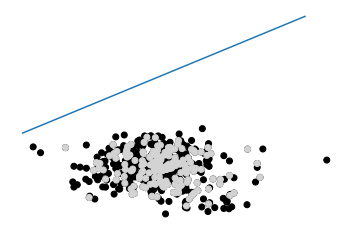

In [791]:
# Plot data points and color using their class
color = ['black' if c == 0 else 'lightgrey' for c in y]
plt.scatter(X[:,0], X[:,1], c=color)

# Create the hyperplane
w = linear_svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-2.5, 2.5)
yy = a * xx - (linear_svc.intercept_[0]) / w[1]

# Plot the hyperplane
plt.plot(xx, yy)
plt.axis("off"), plt.show();

In [792]:
# instantiate classifier with linear kernel and C=1000.0
linear_svc1000=SVC(kernel='linear', C=1000.0) 

# make predictions on test set
start_time = time.time()
# fit classifier to training set
linear_svc1000.fit(X_train, y_train)

y_pred_test=linear_svc.predict(X_valid)
elapsed_time = time.time() - start_time


# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_valid, y_pred)))
# estimate time
print(f"compute time for linear SVM C=100: {elapsed_time:.3f} seconds")

Model accuracy score with linear kernel and C=1000.0 : 0.8246
compute time for linear SVM C=100: 26.635 seconds


#### SVM mit sigmoidem Kernel ausführen
SVM mit sigmoidem Kernel und C=1.0 ausführen

In [793]:
# instantiate classifier with sigmoid kernel and C=1.0
sigmoid_svc=SVC(kernel='sigmoid', C=1.0) 

# fit classifier to training set
sigmoid_svc.fit(X_train,y_train)

# make predictions on test set
start_time = time.time()
y_pred=sigmoid_svc.predict(X_valid)
elapsed_time = time.time() - start_time

# compute and print accuracy score
print('Model accuracy score with sigmoid kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_valid, y_pred)))
# estimate time
print(f"compute time for sigmoid SVM C=11: {elapsed_time:.3f} seconds")

Model accuracy score with sigmoid kernel and C=1.0 : 0.8450
compute time for sigmoid SVM C=11: 0.004 seconds


#### SVM mit polynomialem Kernel ausführen
SVM mit polynomialem Kernel und C=1.0 ausführen

In [794]:
# instantiate classifier with polynomial kernel and C=1.0
poly_svc=SVC(kernel='poly', C=1.0) 

# fit classifier to training set
poly_svc.fit(X_train,y_train)

# make predictions on test set
start_time = time.time()
y_pred_test=poly_svc.predict(X_valid)
elapsed_time = time.time() - start_time

# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_valid, y_pred)))
# estimate time
print(f"compute time for poly SVM C=100: {elapsed_time:.3f} seconds")

Model accuracy score with polynomial kernel and C=1.0 : 0.8450
compute time for poly SVM C=100: 0.004 seconds


Der polynomiale Kernel liefert eine schlechte Leistung. Möglicherweise passt er sich zu stark an die Trainingsmenge an.

#### SVM mit polynomialem Kernel und C=100.0 ausführen

In [795]:
# instantiate classifier with polynomial kernel and C=100.0
poly_svc100=SVC(kernel='poly', C=100.0) 

# fit classifier to training set
poly_svc100.fit(X_train, y_train)

# make predictions on test set
start_time = time.time()
y_pred_test=poly_svc100.predict(X_valid)
elapsed_time = time.time() - start_time

# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_valid, y_pred)))
# estimate time
print(f"compute time for poly SVM C=100: {elapsed_time:.3f} seconds")

Model accuracy score with polynomial kernel and C=1.0 : 0.8450
compute time for poly SVM C=100: 0.003 seconds



#### Vergleich der Genauigkeit von Trainings- und Testsatz
Jetzt vergleiche ich die Genauigkeit des Trainings- und des Testsatzes, um zu prüfen, ob die Anpassung zu hoch ist.

In [796]:
y_pred_train = linear_svc.predict(X_train)

y_pred_train
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.8947


Wir sehen, dass die Genauigkeit des Trainingssets und des Test-Sets sehr vergleichbar sind.

#### Überprüfung auf Über- und Unteranpassung

In [797]:
print('Training set score: {:.4f}'.format(linear_svc.score(X_train, y_train)))

print('Validation set score: {:.4f}'.format(linear_svc.score(X_valid, y_valid)))

Training set score: 0.8947
Validation set score: 0.9094


#### In diesem Diagramm sehen Sie die Trainings- und Validierungsergebnisse einer SVM für verschiedene Werte des Kernelparameters Gamma.

 Bei sehr niedrigen Gammawerten können Sie sehen, dass sowohl der Trainingswert als auch der Validierungswert niedrig sind. Das nennt man Underfitting. Mittlere Gamma-Werte führen zu hohen Werten für beide Bewertungen, d. h. der Klassifikator arbeitet ziemlich gut. Wenn Gamma zu hoch ist, wird der Klassifikator überangepasst, was bedeutet, dass die Trainingspunktzahl gut, aber die Validierungspunktzahl schlecht ist.

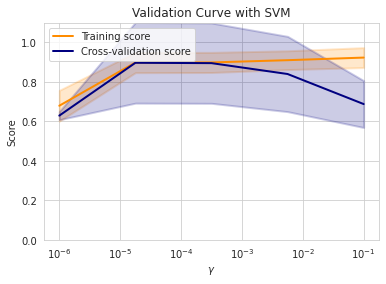

In [799]:
from sklearn.model_selection import validation_curve

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(),
    X_norm,
    y,
    param_name="gamma",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

#### Scikit-learn definiert eine einfache API zum Erstellen von Visualisierungen für maschinelles Lernen.

 Das Hauptmerkmal dieser API besteht darin, schnelles Plotten und visuelle Anpassungen ohne Neuberechnung zu ermöglichen. Wir stellen DisplayKlassen bereit, die zwei Methoden zum Erstellen von Diagrammen verfügbar machen: from_estimator und from_predictions. Die from_estimatorMethode nimmt einen angepassten Schätzer und einige Daten ( X und y) und erstellt ein DisplayObjekt. Manchmal möchten wir die Vorhersagen nur einmal berechnen und sollten sie from_predictions stattdessen verwenden. wir zeichnen eine ROC-Kurve für eine angepasste Support-Vektor-Maschine:

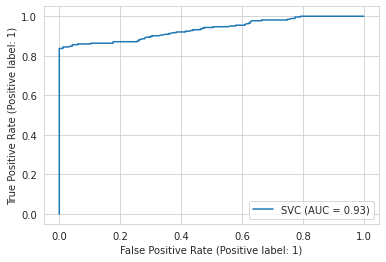

In [800]:
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay


X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state=42)
svc = SVC(random_state=42)
svc.fit(X_train, y_train)

svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test)

#### SVM mit sigmoidem Kernel und C=100.0 ausführen

In [801]:
# instantiate classifier with sigmoid kernel and C=100.0
sigmoid_svc100=SVC(kernel='sigmoid', C=100.0) 

# fit classifier to training set
sigmoid_svc100.fit(X_train,y_train)

# make predictions on test set
start_time = time.time()
y_pred=sigmoid_svc.predict(X_valid)
elapsed_time = time.time() - start_time

# compute and print accuracy score
print('Model accuracy score with sigmoid kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_valid, y_pred)))
print(f"compute time for sigmoid SVM C=100: {elapsed_time:.3f} seconds")

Model accuracy score with sigmoid kernel and C=100.0 : 0.8450
compute time for sigmoid SVM C=100: 0.004 seconds


Es ist zu erkennen, dass der Sigmoid-Kernel genauso schlecht abschneidet wie der Polynom-Kernel.

### Zusammenfassung
Wir erhalten die höchste Genauigkeit mit`linear` Kernel mit C=1.0.  die Genauigkeit von über 90%. Aus der obigen Analyse können wir schließen, dass die Genauigkeit unseres Klassifizierungsmodells sehr gut ist. Unser Modell leistet eine sehr gute Arbeit bei der Vorhersage der Klassenbezeichnungen.


#### Hyperparameter-Abstimmung mit Gittersuche und Kreuzvalidierung

In [802]:
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [ ]:
# Performing CV to tune parameters for best SVM fit 
start_time = time.time()


svm_model = GridSearchCV(SVC(), params_grid, cv=5)

clf = svm_model.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"compute time for parameters tune for best SVM : {elapsed_time:.3f} seconds")

#### Nach der Anpassung kann das Modell dann verwendet werden, um label von neue Sensordaten vorherzusagen

In [ ]:
print(clf.predict([[0.14342208, -0.03019968, -0.04442681, -0.23942335, -0.52969269,
       -0.66097646, -0.00215101,  0.01493005, -0.03802191]]))

#### Konfusionsmatrix und Genauigkeitswert

In [ ]:
# from sklearn import preprocessing

# le = preprocessing.LabelEncoder()
# le.fit([1, 2, 2, 6])
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")
start_time = time.time()

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_valid)
Y_pred_label = list(encoder.inverse_transform(Y_pred))
elapsed_time = time.time() - start_time
print(f"compute the for best kernel for svm : {elapsed_time:.3f} seconds")
#Y_pred_label

In [ ]:
# Making the Confusion Matrix
#print(pd.crosstab(Y_test_label, Y_pred_label, rownames=['Actual Activity'], colnames=['Predicted Activity']))
print(confusion_matrix(y_valid,Y_pred))
print("\n")
print(classification_report(y_valid,Y_pred))

print("Training set score for SVM: %f" % final_model.score(X_train , y_train,  zero_division=1))
print("Validation set score for SVM: %f" % final_model.score(X_valid  , y_valid, zero_division=1 ))

#### SVM model speichern Linear SVM
speicherrun des modells und testen des Modells

In [ ]:
import pickle
# instantiate classifier with default hyperparameters
svc = SVC() 
start_time = time.time()
# fit classifier to training set
svc.fit(X_train,y_train)
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(svc, open(filename, 'wb'))
# make predictions on test set
y_pred = svc.predict(X_valid)
elapsed_time = time.time() - start_time
print(f"compute time for  svm with standard parameter: {elapsed_time:.3f} seconds")
# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_valid, y_pred)))
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_valid, y_valid)
print(result)

In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_valid, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_valid, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_valid, y_pred))

##### Zur weiteren Auswertung können Sie auch die Genauigkeit und den Wiedererkennungswert des Modells überprüfen.

### Random-Forest-Klassifikator und zeichnen die zuvor berechnete Roc-Kurve erneut, indem wir die plotMethode des DisplayObjekts verwenden.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(X_train, y_train)

ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, X_valid, y_valid, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)

### Logistik Regession-Modell ohne featuren enginering für die sensordaten

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

start_time = time.time()
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_valid)  # apply scaling on training data


elapsed_time = time.time() - start_time
print('Model Genauigkeit score für Logistik Regression : {0:0.4f}'. format(pipe.score(X_test, y_valid)))
print('Wahrscheinlickeit für Logistik Regression einen Nutzer zu erkennen : {0:0.4f}'. format(pipe.predict_proba(X_test)))
print(f"Berechnungszeit der Logitik Regression: {elapsed_time:.3f} seconds")
# Nun trainieren wir ein logistisches Regressionsmodell:
log_reg = LogisticRegression()
# Modell trainieren
log_reg.fit(X, y)
# geschätzten Wahrscheinlichkeiten der Nutzer ermiiteln
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="illegitimerUser")
plt.plot(X_new, y_proba[:, 0], "b--", label="legitimerUser")

### KNN-Klassifikatormodell

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)

start_time = time.time()
# Train the model using the training sets
model.fit(X_train,y_train)
elapsed_time = time.time() - start_time
#Predict Output
predicted= model.predict([[0.14342208, -0.03019968, -0.04442681, -0.23942335, -0.52969269,
       -0.66097646, -0.00215101,  0.01493005, -0.03802191]]) # Numpay Array daten einen neuen Datensatz nicht trainiert
print('Die Vorhergesate Klasse ist : ', predicted)
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

# Unüberwaches Lernen: 



## Clustering: KMeans mit 2 Cluster

### Trainieren wir ein K-Means-Cluster mit diesem Datensatz

In [ ]:
from sklearn.cluster import KMeans
# calculate distortion for a range of number of cluster
distortions = []
for i in range(0, 1):
    kmeans = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    kmeans.fit(X_norm)
    distortions.append(kmeans.inertia_)

# plot
plt.plot(range(0, 1), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

#### initialisierung einer prediktiver Variable

In [ ]:
y_pred = kmeans.fit_predict(X)
y_pred is kmeans.labels_

#### Schwerpunkten anschauen

In [ ]:
kmeans.cluster_centers_

### Neue Features lassen sich leicht dem Cluster zuweisen  und deren Schwerpunkt

In [ ]:
X_new = np.array([[0.14342208, -0.03019968, -0.04442681, -0.23942335, -0.52969269,
       -0.66097646, -0.00215101,  0.01493005, -0.03802191]])
kmeans.predict(X_new)

In [ ]:
# plot the 6 clusters
plt.scatter(
    X[y_pred == 0, 0], X[y_pred == 0, 1],
    s=50, c='blue',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[y_pred == 1, 0], X[y_pred == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

# plt.scatter(
#     X[y_pred == 2, 0], X[y_pred == 2, 1],
#     s=50, c='lightblue',
#     marker='v', edgecolor='black',
#     label='cluster 3'
# )


# plt.scatter(
#     X[y_pred == 2, 1], X[y_pred == 2, 2],
#     s=50, c='yellow',
#     marker='D', edgecolor='black',
#     label='cluster 4'
# )

# plt.scatter(
#     X[y_pred == 3, 0], X[y_pred == 3, 1],
#     s=50, c='black',
#     marker='X', edgecolor='black',
#     label='cluster 5'
# )

# plt.scatter(
#     X[y_pred == 3, 1], X[y_pred == 3, 3],
#     s=50, c='green',
#     marker= 'P', edgecolor='black',
#     label='cluster 6'
# )

# plot the centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()


## KMeans-Modell Erstellung

In [ ]:
from sklearn.cluster import KMeans

start_time = time.time()
kmeans = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_pred = kmeans.fit_predict(X_norm[:,:6])
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

In [ ]:
y_pred is kmeans.labels_

#### Wir können uns auch die Schwerpunkte anschauen, die der Algorithmus gefunden hat

In [ ]:
kmeans.cluster_centers_

#### Neue Datensätzen lassen sich leicht dem Cluster zuweisen, deren Schwerpunkt am nächsten liegt:

In [ ]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

### One-Class-SVM

Dieser Algorithmus passt besser für die Novelty Detection. Sie erinnern sich,
dass ein Kernel-SVM-Klassifikator zwei Klassen aufteilt, indem er zuerst (implizit)
alle Instanzen in einem höher dimensionalen Raum abbildet und die beiden Klassen dann in diesem Raum mithilfe eines linearen SVM-Klassifikators
unterteilt (siehe Kapitel 5). Da wir nur eine Klasse an Instanzen haben,
versucht der One-Class-SVM-Algorithmus stattdessen, die Instanzen in einem
höher dimensionalen Raum zu trennen

# Deep Learning:

## LSTM Model  Speichern und wieder verwenden

### Einfaches LSTM für die Sequenzklassifizierung
Die erste Schicht ist die eingebettete Schicht, die Vektoren mit 32 Längen verwendet, um jedes Wort darzustellen. Die nächste Schicht ist die LSTM-Schicht mit 100 Speichereinheiten (Smart Neurons). Da es sich um ein Klassifizierungsproblem handelt, verwenden Sie schließlich eine dichte Ausgabeschicht mit einem einzelnen Neuron und einer Sigmoid-Aktivierungsfunktion, um 0- oder 1-Vorhersagen für die beiden Klassen (gut und schlecht) im Problem zu treffen.

Da es sich um ein binäres Klassifizierungsproblem handelt, wird log loss als Verlustfunktion verwendet ( binary_crossentropy in Keras). Der effiziente ADAM-Optimierungsalgorithmus wird verwendet. Das Modell ist nur für zwei Epochen geeignet, weil es das Problem schnell überpasst. Eine große Stapelgröße von 64 Bewertungen wird verwendet, um Gewichtsaktualisierungen zu verteilen.

> Indented block



In [ ]:
import tensorflow as tf
# from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

# fix random seed for reproducibility
tf.random.set_seed(9)
# load the dataset but only keep the top sensordata words, zero the rest
sensordata_length = 2376
# (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
# truncate and pad input sequences
max_review_length = 237
x_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
x_valid = sequence.pad_sequences(X_valid, maxlen=max_review_length)

In [ ]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(sensordata_length, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#history = model.fit(x_train, y_train, epochs=5, batch_size=64)
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=5, batch_size=64)
# evaluate the model with the test data 
scores = model.evaluate(x_valid, y_valid, verbose=0)

model.save("report_exec_times_model.h5")
print("Accuracy: %.2f%%" % (scores[1]*100))

### Plot das Ergebnis des Training mit 100 Smart Neuron ohne Dropout

In [ ]:
activation = 'sigmoid'
loss = 'binary_crossentropy'
optimizer = 'Adam'
metrics = 'accuracy'
titledetails =  optimizer, loss, activation
titledetails = (', '.join(titledetails))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy - '+ titledetails)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss - ' + titledetails)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Einfaches LSTM für die Sequenzklassifizierung mit Dropout mit dem LSTM präzise und separat auf die Eingangs- und Rekurrentverbindungen der Speichereinheiten angewendet werden.

Keras bietet diese Funktion mit Parametern auf der LSTM-Schicht, dem Dropout zum Konfigurieren des Eingabe-Dropouts und recurrent_dropout zum Konfigurieren des wiederkehrenden Dropouts.

In [ ]:
import tensorflow as tf
# from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
tf.random.set_seed(9)
# load the dataset but only keep the top sensordata words, zero the rest
sensordata_length = 2376
# (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
# truncate and pad input sequences
max_review_length = 237
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(sensordata_length, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train, validation_data=(x_valid, y_valid), epochs=5, batch_size=64)
# print accuracy 
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

### Plot das Ergebnis des Training mit 100 Smart Neuron mit Dropout und reccurent Dropout

In [ ]:
activation = 'sigmoid'
loss = 'binary_crossentropy'
optimizer = 'Adam'
metrics = 'accuracy'
titledetails =  optimizer, loss, activation
titledetails = (', '.join(titledetails))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy - '+ titledetails)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss - ' + titledetails)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Modell Speichern

In [ ]:
# model.save("lstm_model_UserSensordataRecognition.h5")
# from keras.models import load_model
# modelFromFile = load_model('lstm_model_UserSensordataRecognition.h5')
# modelFromFile.summary()
import pickle
pickle.dump(model, open('model.pkl', 'wb'))

# Importieren neue Daten untrainieten Datensätze

In [ ]:
New_Data_normalUser_RH = "/content/drive/MyDrive/Masterarbeit_2021-2022/datasets/Test_P1_Stehen_RechterHand/" # Rechte Hand
New_Data_normalUser_LH = "/content/drive/MyDrive/Masterarbeit_2021-2022/datasets/Test_P1_Stehen_LinkerHand/"  # Linke Hand

### Verkettung von untrainieten Daten 

### Import untrainnieten Datensätze legitimer User

In [ ]:
def concatenateSensorsData_nU(dataPath):
    #global df_GyroSensors
    sensors_files = glob.glob(dataPath + "*.csv")
    for filename in os.listdir(dataPath):
        sensor_file = os.sep.join([dataPath, filename])
        basename = os.path.basename(sensor_file)
        if  basename == "SensorDataAccel.csv":
            headers = ['Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Timestamps']
            # read_csv as pandas data frame
            df_AccelSensors = pd.read_csv(sensor_file, names=headers)
            #  add the features classes of the sensors_files
            #df_AccelSensors['classes'] = pd.Series([classes for x in range(len(df_AccelSensors.index))])
            # print(df_AccelSensors.head(10))

        if  basename == "SensorDataGrav.csv":
            #print(sensor_file)
            headers = ['Gravity_X', 'Gravity_Y', 'Gravity_Z', 'Timestamps']
            # read_csv as pandas data frame
            df_GravSensors = pd.read_csv( sensor_file, names=headers)
            #  add the features classes of the sensors_files
            #df_GravSensors['classes'] = pd.Series([classes for x in range(len(df_GravSensors.index))])
            #print(df_GravSensors.head(10))

        if  basename == "SensorDataGyros.csv":
            #print(sensor_file)
            headers = ['Gyroscope_X', 'Gyroscope_Y', 'Gyroscope_Z', 'Timestamps']
            # read_csv as pandas data frame
            df_GyroSensors = pd.read_csv( sensor_file, names=headers)
            #  add the features classes of the sensors_files
            #df_GyroSensors['classes'] = pd.Series([classes for x in range(len(df_GyroSensors.index))])
            #print(df_GyroSensors)
    df = pd.concat([df_GyroSensors, df_GravSensors, df_AccelSensors], axis=1)
    # # Drop duplicate columns
    # # Use groupby() to drop duplicate columns
    df = df.T.groupby(level=0).first().T
    # print(df)
    # print("len of Data: {}".format(df.shape))
    return  df
    #df.to_csv('df_highRiskUsers.csv')
    #df.to_csv('df_mediumRiskUsers.csv')
    #df.to_csv('df_normalUsers.csv')
    
df_LH = concatenateSensorsData_nU(New_Data_normalUser_LH)
df_RH = concatenateSensorsData_nU(New_Data_normalUser_RH)
# Verkettung der Datensätze
df_sensordata_new = pd.concat([df_LH, df_RH])
df_sensordata_new = df_sensordata_new.iloc[:, :9]
df_sensordata_new
# X_new = df_sensordata_new.to_numpy()
# print("Shape zu Beginn:\t",X.shape)

# im_cols = 9
# im_rows = int(X.shape[1] / im_cols)
# im_shape = (im_rows, im_cols)
# X = X.reshape(X.shape[0], *im_shape)

# print("Shape nach Umformung:\t",X.shape)

# # Multiplying arrays
# X_new

### old-Code

In [ ]:
# # Extraktion der Featuren/Merkmalen aus den Raws daten
# all_files_1 = glob.glob(os.path.join(New_Data_normalUser_LH , "*.csv"))
# li_nU = []
# for filename in all_files_1:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     li_nU.append(df)       
# li_nU[0]

# all_files_2 = glob.glob(os.path.join(New_Data_normalUser_RH , "*.csv"))
# re_nU = []
# for filename in all_files_2:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     re_nU.append(df)       
# re_nU[1]

In [ ]:
# pickled_model = pickle.load(open('model.pkl', 'rb'))
# pickled_model.predict(df_sensordata_new)
# #  Move Timestamps Column To Be The Last In Pandas
# df_nU = df.reindex(columns = [col for col in df.columns if col != 'Timestamps'] + ['Timestamps'])

# # Entfernen alle NaN-Werten
# df_sensordata_new = df_sensordata_new.fillna(0)
# df_sensordata_new.isnull().sum()

# # Entfernen unötigen Spalten und reoganisation der Daten satz
# df_sensordata_new = df_sensordata_nU.iloc[:, 9:]
# df_sensordata_nU
# new_cols = ['Accelerometer_X', 'Accelerometer_Y', ' Accelerometer_Z', 
#        'Gravity_X', 'Gravity_Y', 'Gravity_Z', 'Gyroscope_X', ' Gyroscope_Y',
#        'Gyroscope_Z', ' Timestamps']
# df_sensordata_nU=df_sensordata_nU.reindex(columns=new_cols)


#### Daten vorverarbeiten

In [ ]:
# Extraktion der Sensordaten Normal User
X_NU = df_sensordata_new
X_NU = pd.DataFrame(X_NU)
# Konvertierung der Datensätze in float
X_NU = X_NU.astype(float)
# Scaling the feature 
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_NU = scaler.fit_transform(X_NU)
X_NU
# Convert all columns to floats

In [ ]:
# fix random seed for reproducibility
tf.random.set_seed(9)
# load the dataset but only keep the top sensordata words, zero the rest
sensordata_length = 2376
# (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
# truncate and pad input sequences
max_review_length = 237
x_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
x_valid = sequence.pad_sequences(X_valid, maxlen=max_review_length)

### Import untrainnieten Datensätze illegitimer User

In [ ]:
from keras.models import load_model

#model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5

MODEDL_PATH = '/content/drive/MyDrive/Masterarbeit_2021-2022/models/userRecognitionSensordata.h5'
tf.keras.models.save_model(
model,
MODEDL_PATH,
overwrite=True,
include_optimizer=True,
save_format=None
)

In [ ]:
# # Extraktion der Featuren/Merkmalen aus den Raws daten
# all_files = glob.glob(os.path.join(path_dir_riskuser , "*.csv"))
# re_rU = []
# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     re_rU.append(df)       
# re_rU[0]

# # Verkettung Der Datensätzen
# df = pd.concat(re_rU, axis=0, ignore_index=True)
# #  Move Timestamps Column To Be The Last In Pandas
# df_rU = df.reindex(columns = [col for col in df.columns if col != 'Timestamps'] + ['Timestamps'])

# # Entfernen alle NaN-Werten
# df_sensordata_rU = df_rU.fillna(0)
# df_sensordata_rU.isnull().sum()

# # Entfernen unötigen Spalten und reoganisation der Daten satz
# df_sensordata_rU = df_sensordata_rU.iloc[:, :-1]
# new_cols = ['Accelerometer_X', 'Accelerometer_Y', ' Accelerometer_Z', 
#        'Gravity_X', 'Gravity_Y', 'Gravity_Z', 'Gyroscope_X', ' Gyroscope_Y',
#        'Gyroscope_Z', 'Timestamps']
# df_sensordata_rU=df_sensordata_rU.reindex(columns=new_cols)

# # Extraktion der Sensordaten Risk User
# X_RU = df_sensordata_rU.values[:, -1]
# # Konvertierung der Datensätze in float
# X_RU = X_RU.astype(float)
# # Scaling the feature 
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_RU = scaler.fit_transform(X_RU)
# X_RU[1]
# # Convert all columns to floats